# EDA for Future Loan Prediction

## Problem Statement
Numida: Can we biuld a model that will predict the performance of future loan applications. The model will be used to set interest rates and support Loan Officers’ decision making when completing Due Diligence.

## Objective

- to build a model that will predict the performance of future loan applications
- this model will be used to set interest rate and support loan approval decission making

## Dataset
- raw dataset has been supplied by Numida

##### _Supplied knowledge about dataset_
- from `loan_number`, `approval_status`, to the last feature are available after the loan has been approved.

##### _Busniess knowledge to consider_
- "Numida tries to find a reason to lend, rather than looking for a reason to not lend"

- Customers that repay on-time are more likely to be retained
- Customer that pays back more than 15 days late rearly get another loan
- 'Yield' is one of the most important metrics for load approval
- Numida generally expect 5% - 10% of the laon to be written off


## Decision underlying Target Creation
Given the objective and the above _business knowledge_, we need to consider both customer retention and profitability as key objectives. Since customers who repay on time are more valuable for long-term business, and those who pay back late are less likely to be retained, the target variable should reflect these factors. It should capture both loan performance and  business values.
- We will use features collected after loan approval to estimate the target variable, since they show the future performances of the "then" applications
--------------------------------------------
- _NOTE: If we are interested in building a model that can be used for first time applicants, we will use features that are available during application for training the model. This is because features that are only available after the loan has been approved (or declined) has no contribution in the approval decission or setting of interest rate of a first time applicant_

## Problem Framing for possible targets
ML Engineer: Can we build a loan performance model which can predict
1.  **Default/Not** 
2. present **probability descision boundry** for approval/rejection
***************************************************************
#### For future checks
2. identy future loan as **Good/Medium/Poor** retention potential
3. present **probability descision boundry** for  Good/Meduim/Poor retention potential

## Decisions for EDA and feature engineering:
- What are the features we can use? We can only use features which were available at 
the application stage
- What should be the output of the model? The model has to output a decision rather 
than a probability score.

We can frame this as **supervised binary classification problem**. The model will be trained on past loans applications where target is already known. Each of these loans would either have 
defaulted or not. 

### EDA
1. Filter Approved data
2. Deal with missing values
3. Create target variable
4. Engineer features from application data
5. Check Information value of each feature with relation to the target value
##### STEP 0:  Import Libs

In [1]:
# import lib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')


#####  Read data into pandas and investigate the properties

In [2]:
train_df = pd.read_csv("../data/raw/train_loan_data.csv")
train_payment_df = pd.read_csv("../data/raw/train_payment_data.csv")
test_df = pd.read_csv("../data/raw/test_loan_data.csv")


In [3]:
train_df.head(10)

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
0,860706,604923,131449.0,NaN,Friend,Beauty Fashion,300000.0,345500.0,1,1,1.0,1.0,Approved,False,345500.0,345500.0,45500.0
1,975605,604923,131449.0,NaN,Friend,Beauty Fashion,330000.0,380000.0,2,2,2.0,1.0,Approved,False,380000.0,380000.0,50000.0
2,126416,122438,NaN,Client does not have all of the requirements,Friend,Food Staple Goods,300000.0,NaN,1,1,NaN,1.0,Declined,False,NaN,NaN,NaN
3,127617,122438,108019.0,NaN,Friend,Food Staple Goods,200000.0,221100.0,2,1,1.0,1.0,Approved,False,221100.0,221100.0,21100.0
4,148416,122438,108019.0,NaN,Friend,Food Staple Goods,220000.0,243200.0,3,2,2.0,1.0,Approved,False,243200.0,243200.0,23200.0
5,172015,122438,108019.0,NaN,Friend,Food Staple Goods,242000.0,269000.0,4,3,3.0,1.0,Approved,False,269000.0,269000.0,27000.0
6,202481,122438,108019.0,NaN,Friend,Food Staple Goods,266200.0,295800.0,5,4,4.0,1.0,Approved,True,200000.0,295800.0,29600.0
7,244947,122438,108019.0,NaN,Friend,Food Staple Goods,292800.0,343100.0,6,5,5.0,1.0,Approved,False,343100.0,343100.0,50300.0
8,289710,122438,108019.0,NaN,Friend,Food Staple Goods,322100.0,367800.0,7,6,6.0,1.0,Approved,False,367800.0,367800.0,45700.0
9,325580,122438,108019.0,NaN,Friend,Food Staple Goods,350000.0,399600.0,8,7,7.0,1.0,Approved,False,399600.0,399600.0,49600.0


In [4]:
train_payment_df.head(10)


,loan_id,paid_at,amount,transaction_type
0,834148,2023-11-25 17:44,200000.0,Deposit
1,4028,2019-02-09 16:55,1036300.0,NaN
2,4798,2019-04-25 15:50,1228500.0,NaN
3,2082,2018-08-22 10:41,50000.0,NaN
4,3802,2019-01-05 16:00,1384600.0,NaN
5,2082,2018-09-05 07:53,50000.0,NaN
6,2296,2018-07-24 10:12,50000.0,NaN
7,2296,2018-07-13 23:14,50000.0,NaN
8,4851,2019-05-01 18:28,312200.0,NaN
9,4851,2019-04-20 14:05,100000.0,NaN


In [5]:
test_df.head(10)

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,payment_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
0,1003730,604923,131449,NaN,Friend,Beauty Fashion,350000.0,399500.0,3,3,3,1.0,Approved,Paid up,False,399500.0,399500.0,49500.0
1,986527,122438,279289,NaN,Friend,Food Staple Goods,1500000.0,1771000.0,30,27,27,1.0,Approved,Paid up,False,1771000.0,1771000.0,271000.0
2,985254,675619,279290,NaN,Sales Team,Metal and Woodworking,578400.0,648400.0,2,2,2,NaN,Approved,Paid up,False,648400.0,648400.0,70000.0
3,989887,312482,108022,NaN,Friend,Mobile Money Airtime,650000.0,768300.0,20,19,19,1.0,Approved,Written off,True,0.0,0.0,-650000.0
4,994582,654630,137987,NaN,Friend,Hospitality,594000.0,665900.0,3,3,3,NaN,Approved,Paid up,False,665900.0,665900.0,71900.0
5,987152,665745,279290,NaN,Friend,School,360000.0,414500.0,2,2,2,NaN,Approved,Paid up,False,414500.0,414500.0,54500.0
6,1002254,628210,137991,NaN,Facebook,Food Staple Goods,431300.0,483500.0,5,5,5,NaN,Approved,Paid up,False,483500.0,483500.0,52200.0
7,1010717,489901,57802,NaN,Friend,Phones Electronics,1771900.0,1983800.0,11,11,11,2.0,Approved,Paid up,False,1983800.0,1983800.0,211900.0
8,986382,286498,279292,NaN,Friend,Mobile Money Airtime,1149800.0,1322900.0,8,8,8,1.0,Approved,Paid up,False,1322900.0,1322900.0,173100.0
9,993266,645363,201649,NaN,Friend,Mobile Money Airtime,742500.0,832100.0,4,4,4,NaN,Approved,Paid up,False,832100.0,832100.0,89600.0


In [6]:
# Know the shapes
print("\n train: \t",train_df.shape, "\n train Payemets: ", train_payment_df.shape,"\n test: \t",test_df.shape)


 train: 	 (25102, 17) 
 train Payemets:  (83275, 4) 
 test: 	 (2000, 18)


##### _Observation_
- the **train payemnt data** has more number of rows compaired to the **train**. This implies that multiple payment are made by some borrower.
##### Required Action
- We need to use this information to engineer features

In [7]:
# Know the shapes
print("\n train: \t",train_df.info(), "\n train Payemets: ", train_payment_df.info(),"\n test: \t",test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25102 entries, 0 to 25101
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   25102 non-null  int64  
 1   business_id               25102 non-null  int64  
 2   credit_officer_id         24630 non-null  float64
 3   dismissal_description     554 non-null    object 
 4   acquisition_channel       25102 non-null  object 
 5   sector                    25102 non-null  object 
 6   principal                 25102 non-null  float64
 7   total_owing_at_issue      23938 non-null  float64
 8   application_number        25102 non-null  int64  
 9   applying_for_loan_number  25102 non-null  int64  
 10  loan_number               23938 non-null  float64
 11  employee_count            24246 non-null  float64
 12  approval_status           25102 non-null  object 
 13  paid_late                 25102 non-null  bool   
 14  total_

#### Basic checks to understand data types, missing values, and unique values in each feature.

In [8]:

# Check for missing values in percentage terms
train_missing = train_df.isnull().sum() / len(train_df) * 100
train_payment_missing = train_payment_df.isnull().sum() / len(train_payment_df) * 100

train_missing, train_payment_missing


(loan_id                      0.000000
 business_id                  0.000000
 credit_officer_id            1.880328
 dismissal_description       97.793005
 acquisition_channel          0.000000
 sector                       0.000000
 principal                    0.000000
 total_owing_at_issue         4.637081
 application_number           0.000000
 applying_for_loan_number     0.000000
 loan_number                  4.637081
 employee_count               3.410087
 approval_status              0.000000
 paid_late                    0.000000
 total_recovered_on_time      4.637081
 total_recovered_15_dpd       4.637081
 cash_yield_15_dpd            4.637081
 dtype: float64,
 loan_id             0.000000
 paid_at             0.000000
 amount              0.000000
 transaction_type    3.989192
 dtype: float64)

In [9]:
# Convert `paid_at` to datetime in train_payment_df
train_payment_df['paid_at'] = pd.to_datetime(train_payment_df['paid_at'])

# We keep ids in a list for easy access
id_features = ['loan_id', 'business_id', 'credit_officer_id']



In [10]:

# use list comprehension to remove the id features
def get_loan_numerical_fe(df,id_features):
    '''
    Returns numerical features other than IDs
    '''
    all_numerical_features = df.select_dtypes(include=['int', 'float']).columns.tolist()
    return [fe for fe in all_numerical_features if fe not in id_features]



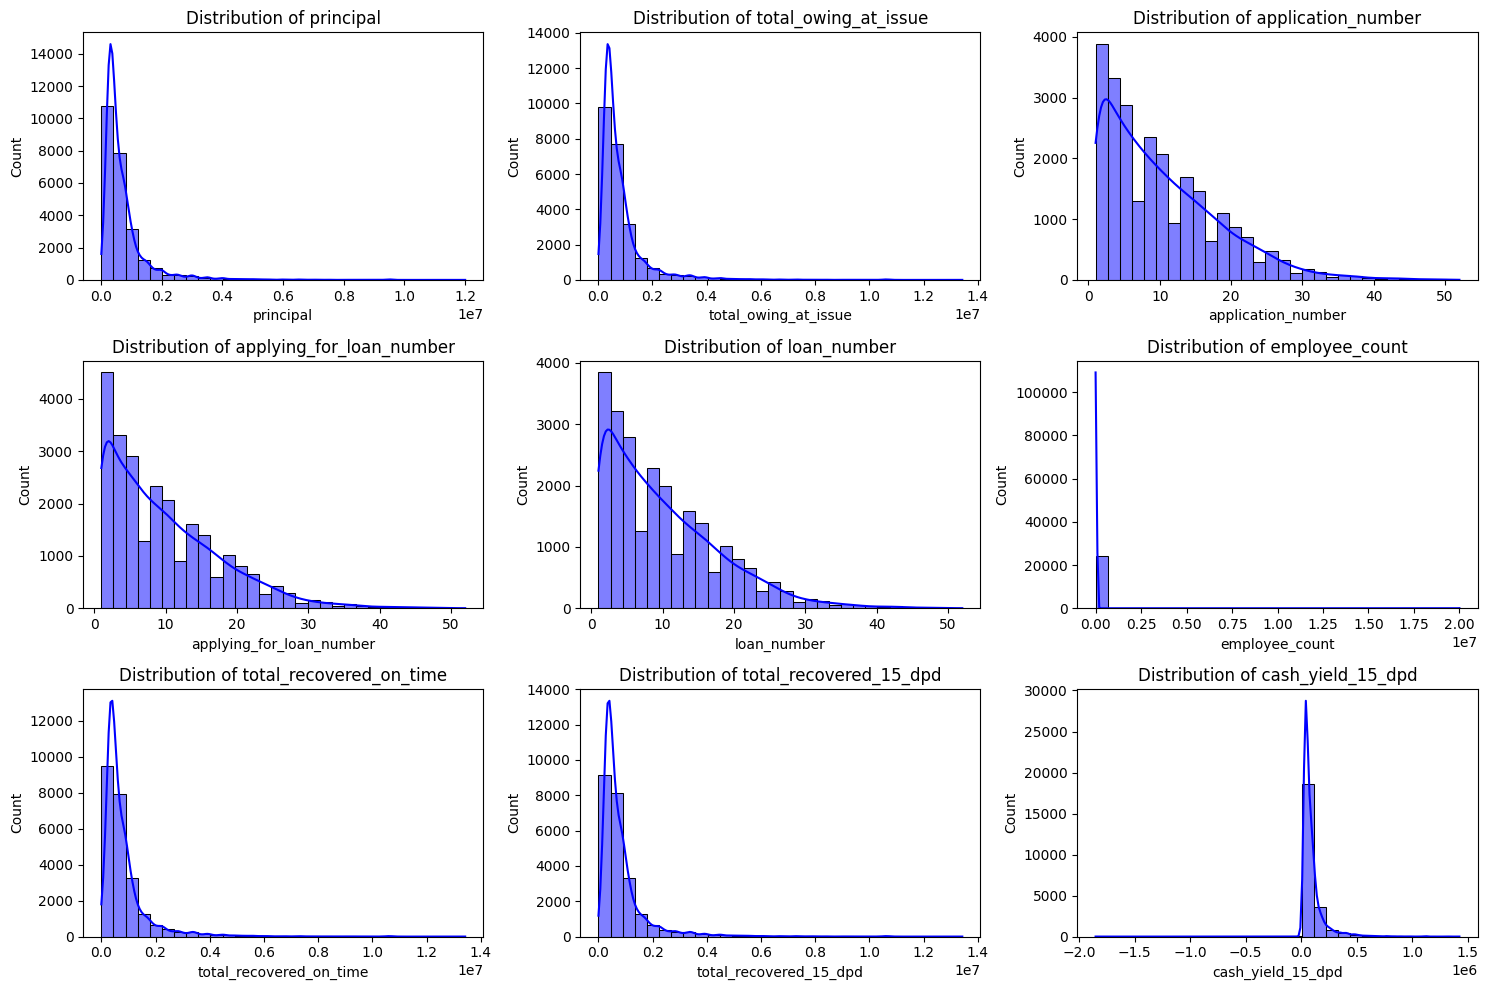

In [11]:
numerical_features = get_loan_numerical_fe(train_df,id_features)
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(train_df[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()


In [12]:

# Analyze unique values for categorical features
categorical_features = train_df.select_dtypes(include="object").columns

for feature in categorical_features:
    print(f"Unique values in {feature}:\n", train_df[feature].unique(), "\n")


Unique values in dismissal_description:
 [nan 'Client does not have all of the requirements'
 'Client travelling away from business' 'Unable to contact client'
 'Client does not have ID' 'Expired' 'Trading license is fake'
 'Client does not have business' 'Client no longer interested'
 'Client blacklisted from Numida'
 'Client thought that loan amount was too small'
 'Client has just started new business (<6 months)'
 'Client is not owner of business' 'Fraudulent Transactions'
 'Concentration risk in same shop'
 'Client does not have multiple loan requirements'
 'Client has active Numida loan on different number'
 'Client got money elsewhere'
 'Client will reapply when loan limit increases'
 'Client was testing loan feature' 'Business revenues too low to finance'
 "Someone used client's phone to apply for loan"
 'Client thought requirements were too onerous'
 'Loan purpose is not for business use'
 'Client does not have mobile money account in their name'
 'Client does not have smartph

In [13]:
# Analyze unique values for categorical features
categorical_features_payment = train_payment_df.select_dtypes(include="object").columns

for feature in categorical_features_payment:
   print(f"Unique values in {feature}:\n", train_payment_df[feature].value_counts(), "\n")


Unique values in transaction_type:
 transaction_type
Deposit     78215
Discount     1738
Name: count, dtype: int64 



##### _Observation_
- the `approval_status` has other values than **approved*. Ideally, we want to train our model with application data from approved loans.
- we won't use features with more than 50% missing data

##### Required Action
- Drop rows where `approval_status` is not **approved** 
- Drop `dismissal_description` 

In [14]:

train_high_missing = train_missing[train_missing> 50].index.tolist()
train_df.drop(train_high_missing, axis=1, inplace=True)
train_df = train_df[train_df['approval_status'] == 'Approved']
print("\n Shape: ", train_df.shape, "\n Unique Status Count: \n",train_df['approval_status'].value_counts())



 Shape:  (23938, 16) 
 Unique Status Count: 
 approval_status
Approved    23938
Name: count, dtype: int64


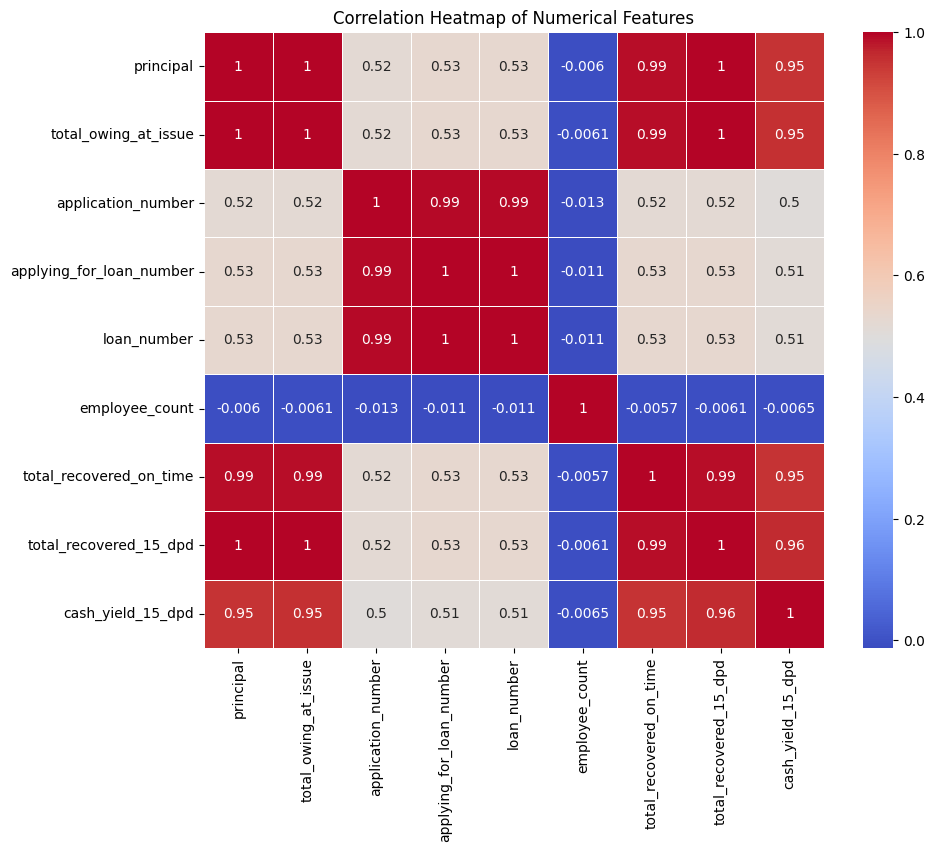

In [15]:

# Correlation heatmap of numerical features
numerical_features = get_loan_numerical_fe(train_df, id_features)
plt.figure(figsize=(10, 8))
corr_matrix = train_df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


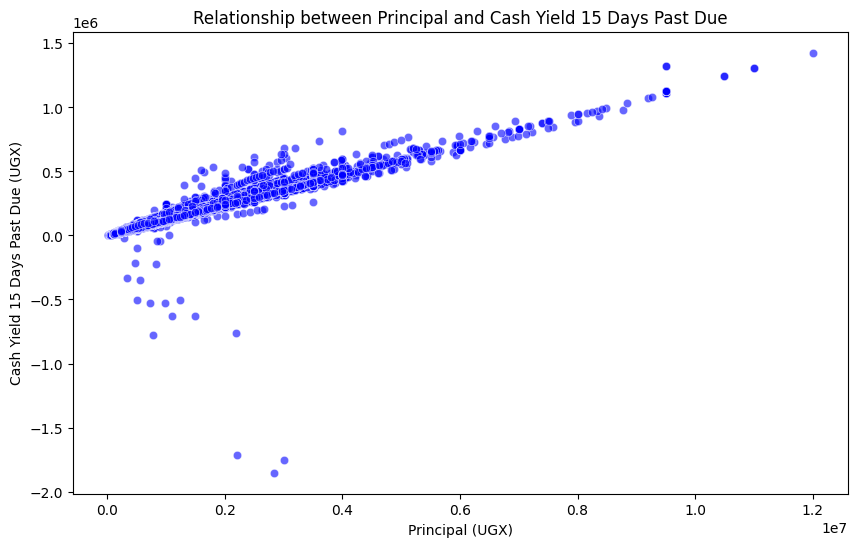

In [16]:


# Plot the relationship between 'principal' and 'cash_yield_15_dpd'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='principal', y='cash_yield_15_dpd', alpha=0.6, color='blue')
plt.title('Relationship between Principal and Cash Yield 15 Days Past Due')
plt.xlabel('Principal (UGX)')
plt.ylabel('Cash Yield 15 Days Past Due (UGX)')
plt.show()

#### _Observation_
- less Principal, less yield

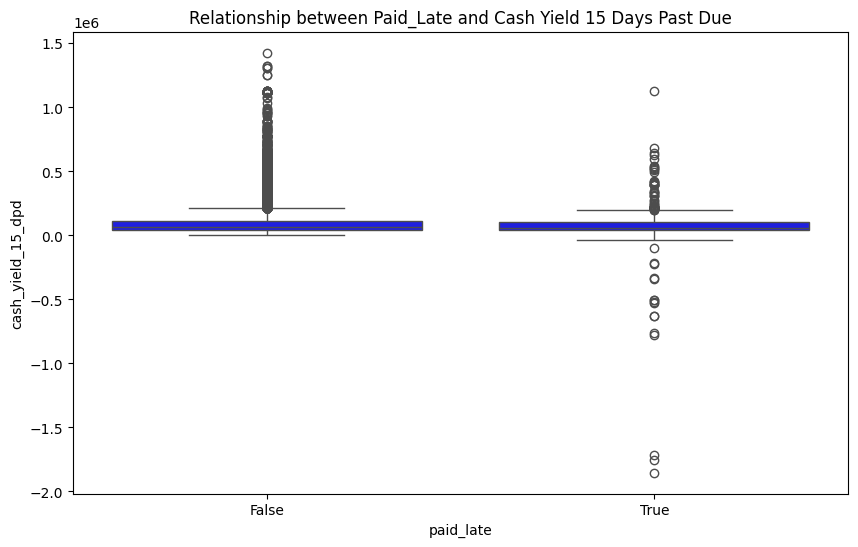

In [17]:


# Plot the relationship between 'principal' and 'cash_yield_15_dpd'
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='paid_late', y='cash_yield_15_dpd', color='blue')
plt.title('Relationship between Paid_Late and Cash Yield 15 Days Past Due')
plt.xlabel('paid_late')
plt.show()

#### _Observation_
Some borrowers who paid late still contributed to positive yield. It may be useful not categorize all paid_late as Default.

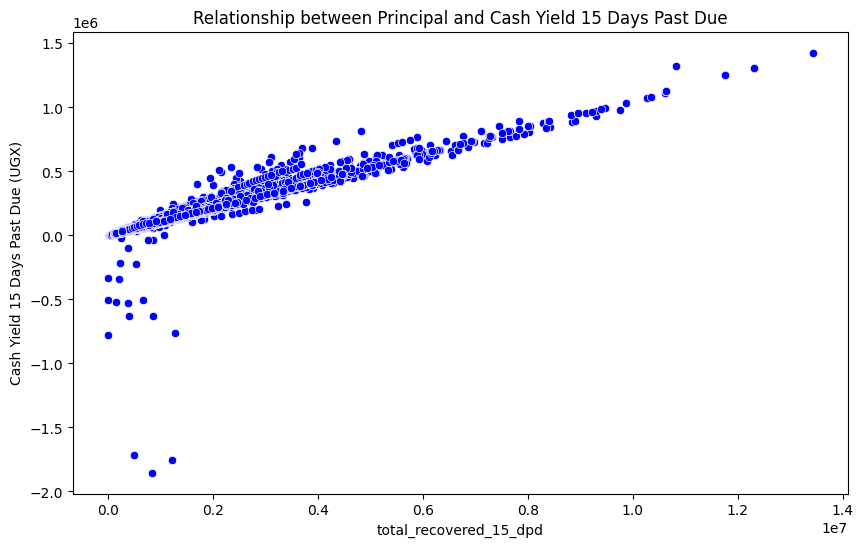

In [18]:


# Plot the relationship between 'principal' and 'cash_yield_15_dpd'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='total_recovered_15_dpd', y='cash_yield_15_dpd', color='blue')
plt.title('Relationship between Principal and Cash Yield 15 Days Past Due')
plt.xlabel('total_recovered_15_dpd')
plt.ylabel('Cash Yield 15 Days Past Due (UGX)')
plt.show()

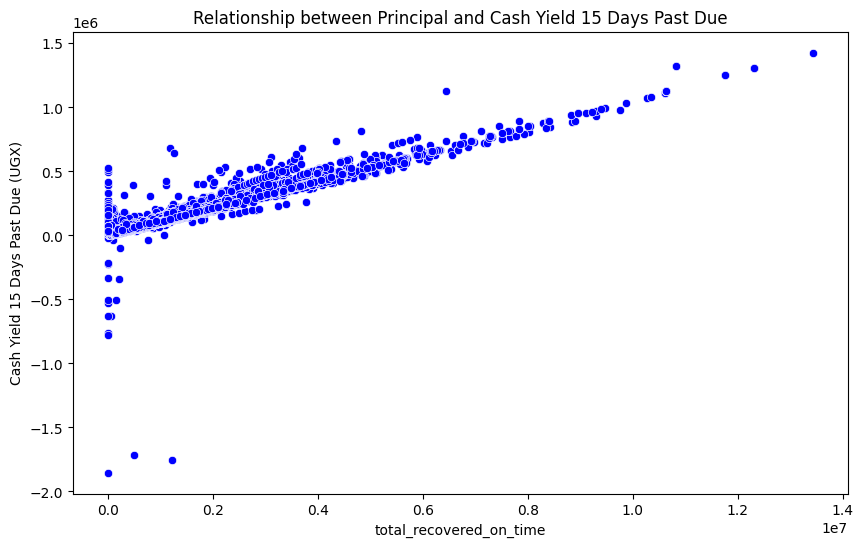

In [19]:


# Plot the relationship between 'principal' and 'cash_yield_15_dpd'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='total_recovered_on_time', y='cash_yield_15_dpd', color='blue')
plt.title('Relationship between Principal and Cash Yield 15 Days Past Due')
plt.xlabel('total_recovered_on_time')
plt.ylabel('Cash Yield 15 Days Past Due (UGX)')
plt.show()

#### _Observation_
- There are very high correlation among many features. 
- The features are not normally distributed
#### _Action_
- droping collerated features may not be a good idea as it looks like the nature of the business, thus it makes sense to first explore algorithms that are:
    - scale invariant
    - robust to multi-collinearity
    - robust to outliers

## Next

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23938 entries, 0 to 25101
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   23938 non-null  int64  
 1   business_id               23938 non-null  int64  
 2   credit_officer_id         23938 non-null  float64
 3   acquisition_channel       23938 non-null  object 
 4   sector                    23938 non-null  object 
 5   principal                 23938 non-null  float64
 6   total_owing_at_issue      23938 non-null  float64
 7   application_number        23938 non-null  int64  
 8   applying_for_loan_number  23938 non-null  int64  
 9   loan_number               23938 non-null  float64
 10  employee_count            23137 non-null  float64
 11  approval_status           23938 non-null  object 
 12  paid_late                 23938 non-null  bool   
 13  total_recovered_on_time   23938 non-null  float64
 14  total_recov

In [21]:
train_payment_df.head(20).sort_index

<bound method DataFrame.sort_index of     loan_id             paid_at     amount transaction_type
0    834148 2023-11-25 17:44:00   200000.0          Deposit
1      4028 2019-02-09 16:55:00  1036300.0              NaN
2      4798 2019-04-25 15:50:00  1228500.0              NaN
3      2082 2018-08-22 10:41:00    50000.0              NaN
4      3802 2019-01-05 16:00:00  1384600.0              NaN
5      2082 2018-09-05 07:53:00    50000.0              NaN
6      2296 2018-07-24 10:12:00    50000.0              NaN
7      2296 2018-07-13 23:14:00    50000.0              NaN
8      4851 2019-05-01 18:28:00   312200.0              NaN
9      4851 2019-04-20 14:05:00   100000.0              NaN
10     2296 2018-07-14 18:26:00    50000.0              NaN
11   838416 2023-11-25 17:52:00   380000.0          Deposit
12     8810 2019-10-08 08:07:00    30000.0              NaN
13     2443 2018-08-15 18:31:00   100000.0              NaN
14     2082 2018-09-05 15:16:00    10000.0              NaN
15

#### We performed feature engineer to take frequent payment payment into consideration 

In [22]:

# Feature Engineering
def data_engineer(df, train_payment_df):

    #to date
    train_payment_df['paid_at']= pd.to_datetime(train_payment_df['paid_at'])
    
    # Calculate payment_count  for each loan_id in train_payment_df. Consider Deposite Only
    payment_count = train_payment_df[train_payment_df['transaction_type'] == 'Deposit']
    payment_count = payment_count.groupby('loan_id')['amount'].count().reset_index().rename(columns={'amount': 'payment_count'})


    # Calculate repayment_duration_days: difference between first and last payment dates
    first_payment_date = train_payment_df.groupby('loan_id')['paid_at'].min().reset_index().rename(columns={'paid_at': 'first_payment_date'})
    last_payment_date = train_payment_df.groupby('loan_id')['paid_at'].max().reset_index().rename(columns={'paid_at': 'last_payment_date'})
    df = df.merge(first_payment_date, on='loan_id', how='left').merge(last_payment_date, on='loan_id', how='left')

    # Calculate duration in days
    df['repayment_duration_days'] = (df['last_payment_date'] - df['first_payment_date']).dt.days
    df['repayment_duration_days'].fillna(np.max(df['repayment_duration_days']), inplace=True)

    # Drop intermediate date columns to keep dataset clean
    df.drop(['first_payment_date', 'last_payment_date'], axis=1, inplace=True)

    return df


In [23]:
train_df = data_engineer(train_df,train_payment_df)

test_df = data_engineer(test_df,train_payment_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23938 entries, 0 to 23937
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   23938 non-null  int64  
 1   business_id               23938 non-null  int64  
 2   credit_officer_id         23938 non-null  float64
 3   acquisition_channel       23938 non-null  object 
 4   sector                    23938 non-null  object 
 5   principal                 23938 non-null  float64
 6   total_owing_at_issue      23938 non-null  float64
 7   application_number        23938 non-null  int64  
 8   applying_for_loan_number  23938 non-null  int64  
 9   loan_number               23938 non-null  float64
 10  employee_count            23137 non-null  float64
 11  approval_status           23938 non-null  object 
 12  paid_late                 23938 non-null  bool   
 13  total_recovered_on_time   23938 non-null  float64
 14  total_

#### Computer the Target and store the data

In [24]:
def make_train_Target(df):
    '''
    Make Targets values: Default = 1, Not = 0
    '''
    # Compute the median of cash yeild for for Paid_Late = True and Yield > 0 
    avg_yeild_paid_late_true = df.loc[(df['paid_late'] == True) & (df['cash_yield_15_dpd'] > 0),'cash_yield_15_dpd'].median()


    # Use the computed average in combination with Business Knowledge to decide the Target
    df['Target'] = np.where(
        ((df['paid_late'] == True) | (df['cash_yield_15_dpd'] < 0) 
        | (df['total_recovered_on_time'] < df['total_recovered_15_dpd'])) , 1,0)

    return df

In [25]:
train_df = make_train_Target(train_df)
test_df['Target'] = np.where(test_df['payment_status']=="Written off",1,0)
test_df.drop(['dismissal_description','payment_status'], axis=1, inplace=True)


In [26]:
print("\nTrain shape: ", train_df.info(), "\nTest shape: ",test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23938 entries, 0 to 23937
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   23938 non-null  int64  
 1   business_id               23938 non-null  int64  
 2   credit_officer_id         23938 non-null  float64
 3   acquisition_channel       23938 non-null  object 
 4   sector                    23938 non-null  object 
 5   principal                 23938 non-null  float64
 6   total_owing_at_issue      23938 non-null  float64
 7   application_number        23938 non-null  int64  
 8   applying_for_loan_number  23938 non-null  int64  
 9   loan_number               23938 non-null  float64
 10  employee_count            23137 non-null  float64
 11  approval_status           23938 non-null  object 
 12  paid_late                 23938 non-null  bool   
 13  total_recovered_on_time   23938 non-null  float64
 14  total_

In [27]:

# Save final train features to CSV
id_final_train_features_path = "../data/processed/id_final_train_features.csv"
id_final_test_features_path = "../data/processed/id_final_test_features.csv"
train_df.to_csv(id_final_train_features_path, index=False, mode='w')
test_df.to_csv(id_final_test_features_path, index=False, mode='w')



## PART 2

In [28]:
# remove ids
# train_df.drop(id_features, axis=1, inplace=True)
# test_df.drop(id_features, axis=1, inplace=True)
# 



#### Use special package to check feature strenghts as related to the Target.
- This is very helpful to check how imprtant featurs is captured in the definition of Target


In [29]:
from optbinning import OptimalBinning
from pandas.api.types import is_numeric_dtype

target = "Target"
features = [x for x in train_df.columns if x != target]


binned_features = {}

def get_binning(x,y,params={}):
    """
    Get binning result for independent variable  with the target variable y
    """
    if is_numeric_dtype(x):
        optb = OptimalBinning(name=feat, dtype="numerical", solver="cp",**params)
    else :
        optb = OptimalBinning(name=feat, dtype="categorical", solver="mip",**params)
    optb.fit(x, y)
    binning_table = optb.binning_table
    binning_table.build()
    return binning_table,optb
    
for feat in features:
    x = train_df[feat].values
    y = train_df[target]
    
    binning_result = get_binning(x,y)
    binned_features.update({feat :binning_result})


(CVXPY) Oct 07 03:53:37 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 07 03:53:37 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [30]:
feature_strength = pd.DataFrame([ (x,y[0].iv) for x,y in binned_features.items() ]).rename(columns = {0:"feature" , 1:"iv"}).sort_values("iv",ascending=False)
feature_strength.head(10)

,feature,iv
13,total_recovered_on_time,3.129132
4,sector,0.194906
16,repayment_duration_days,0.138201
0,loan_id,0.123621
9,loan_number,0.083614
8,applying_for_loan_number,0.083614
2,credit_officer_id,0.079423
7,application_number,0.076069
1,business_id,0.037114
5,principal,0.033026


In [31]:
feature_strength.iv.describe(np.linspace(0,1,11))

count    17.000000
mean      0.241289
std       0.746066
min       0.000000
0%        0.000000
10%       0.010463
20%       0.020247
30%       0.029100
40%       0.032127
50%       0.037114
60%       0.078082
70%       0.083614
80%       0.115620
90%       0.160883
100%      3.129132
max       3.129132
Name: iv, dtype: float64

#### _Observation_
Many features have very low IV(< 0.05). Idealy, these features may be removed where computing constraints is under consideration. However, we will use TreeBased model. Any feature that has even slight predictive ability, should be included in the training process and the model shoudl itlsef learn how important it is.

Although the yield is not the strongest relationship with the target, graphs above shows that yield also results (although not high) from late and delayed payment. Thus, our target is to eliminate negative yiled and target loan timely recorvery 

In [32]:
# Save final train features to CSV
final_train_features_path = "../data/processed/final_train_features.csv"
final_test_features_path = "../data/processed/final_test_features.csv"
train_df.to_csv(final_train_features_path, index=False, mode='w')
test_df.to_csv(final_test_features_path, index=False, mode='w')
